In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts
import matplotlib.pyplot as plt
import boto3, json, os, warnings, csv

root = "/home/ec2-user/SageMaker"
f = json.load(open(f"{root}/notebook_analysis/avg_ratio/fit_hist_curve/cred.json"))
print(f"Loading bucket_path info sucessfully! {f.keys()}")
s3_bknm = f["s3_bknm"]
s3_fpath = f["s3_fpath"]
lsnkensa = f["lsnkensa"]
drop_col = f["drop_col"]

Loading bucket_path info sucessfully! dict_keys(['s3_bknm', 's3_fpath', 'lsnkensa', 'drop_col', 'host'])


### Loading

In [2]:
s3 = boto3.resource('s3')
s3obj = s3.Object(s3_bknm, s3_fpath).get()
byte_data = s3obj['Body'].read()
str_data = byte_data.decode('utf-8')
lines = [row for row in csv.reader(str_data.splitlines(), delimiter="\t")]
header = lines[0]
content = lines[1:]
ckipax_df = pd.DataFrame(data=content, columns=header).drop(columns=drop_col)
print("Loading ckipax sucessfully!")
display(ckipax_df.head())

kensa_df = pd.read_excel(f"{root}/{lsnkensa}")
kensa_df['nfxryl'] = kensa_df['nfxryl'].astype(str)
print("Loading lsn_kensa data sucessfully!")
display(kensa_df.head())

psg_by_lane = pd.merge(ckipax_df, kensa_df, on = 'nfxryl', how='left').dropna().drop(columns='nfxryl')
psg_by_lane = psg_by_lane[psg_by_lane.kensa.isin(['A','B','C','D'])]
psg_by_lane['hour'] = psg_by_lane['hour'].astype(int)
psg_by_lane['diff'] = psg_by_lane['diff'].astype(int)
print("Joined data sucessfully!")
display(psg_by_lane.head(5))

Loading ckipax sucessfully!


,knfltd,nfxryl,nfxryt,hour,diff
0,20230501,05380,0625,7,35
1,20230501,05480,0544,7,76
2,20230501,05380,0519,7,101
3,20230501,04996,0609,7,51
4,20230501,05306,0632,7,28


Loading lsn_kensa data sucessfully!


,nfxryl,kensa
0,20055,A
1,20056,A
2,20057,A
3,20059,A
4,20060,A


Joined data sucessfully!


,knfltd,nfxryt,hour,diff,kensa
7,20230501,0616,7,44,B
8,20230501,0534,7,86,A
10,20230501,0637,7,23,B
16,20230501,0626,7,34,B
27,20230501,0628,7,32,B


In [3]:
warnings.filterwarnings("ignore")

### How to evaluate the difference between (estimation.fitting.curve and histogram)
- **Hint 1.** After generate the histogram, find the mid-point of each block of histogram, we will obtain 
- **Hint 2.** Now, we will calculate the area between the `fitting_curve (true)` and `est_from_histogram [via mid-point]`
- **Hint 3.** Using `np.trapz(y, x, dx)`

#### Define the some custom function

In [4]:
x1=np.random.normal(0,1,1000)
x2=np.random.normal(3,5,1000)
x = np.concatenate([x1, x2])

## How to find the mid-point of a histogram?
def est_get_kernel(ser, bw):
    """
        To get the mid-point from any input of series (ser) and bin-width (bw)
    """
    xb = np.arange(ser.min(), ser.max(), bw)
    x_range = range(len(xb)-1)
    yb = [((ser >= xb[idx]) & (ser <= xb[idx + 1])).sum() / (bw*len(ser)) for idx in x_range]
    xb = [(xb[idx] + xb[idx + 1])/2 for idx in x_range]

    return xb, yb

def plot_hist_midpoint(ser, bw):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3.5))
    sns.histplot(ser, stat="density", binwidth=bw, color='cyan', ax=ax)
    xbin, ybin = est_get_kernel(ser, bw)
    ax.plot(xbin, ybin, 'red', marker='d', linewidth=2)
    ax.set_title("Histogram and midpoint-segments-connection as an estimation")

def array_interpolation(x_s, xbin, ybin):
    return np.interp(sorted(x_s), xbin, ybin)
    
def illustration_area(ser, bw, dx=1e-5):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 3.5))
    x_s, y = sns.distplot(ser, hist=False, ax=ax[0]).get_lines()[0].get_data()
    xbin, ybin = est_get_kernel(ser, bw)
    ax[0].plot(x_s, y, 'blue', linewidth=4)
    ax[0].plot(xbin, ybin, 'red', marker='d', linewidth=2)
    sns.histplot(ser, stat="density", binwidth=bw, color='cyan', ax=ax[0])
    ax[0].set_title("histogram, true-density (from seaborn) and mid-point-segments of the histogram")
    
    ax[1].plot(x_s, y, 'blue', linewidth=2, label = 'true.density')
    ax[1].plot(xbin, ybin, 'red', marker='d', label = 'mid.point.segments', linewidth=2)
    ax[1].set_title("true-density, the mid-point-segments of the histogram & their between.areas")
    # interpolation
    yinterp = array_interpolation(x_s, xbin, ybin)
    ax[1].fill_between(x_s, y, yinterp, interpolate=True)

    true_integration = np.trapz(y, x_s, dx = dx)
    cust_integration = np.trapz(ybin, xbin, dx = dx)

    print(f"Integration of true-density: {true_integration}")
    print(f"Integration of custom-binwidth [bin = {bw}]: {cust_integration}, cust_err = {abs(true_integration - cust_integration)}")
    
    plt.legend()
    
def error_calc(ser, bw = None, dx = 1e-4):
    x_sort = sorted(ser)
    x_s, y = sns.distplot(x_sort, hist=False).get_lines()[0].get_data()
    if bw == None:
        bw = (ser.max() - ser.min())/np.sqrt(len(ser))
    else:
        bw = bw

    x_bw, y_bw = est_get_kernel(ser, bw)
    true_integration = np.trapz(y, x_s, dx = dx)
    optional_integrate = np.trapz(y_bw, x_bw, dx = dx)

    return abs(true_integration - optional_integrate)

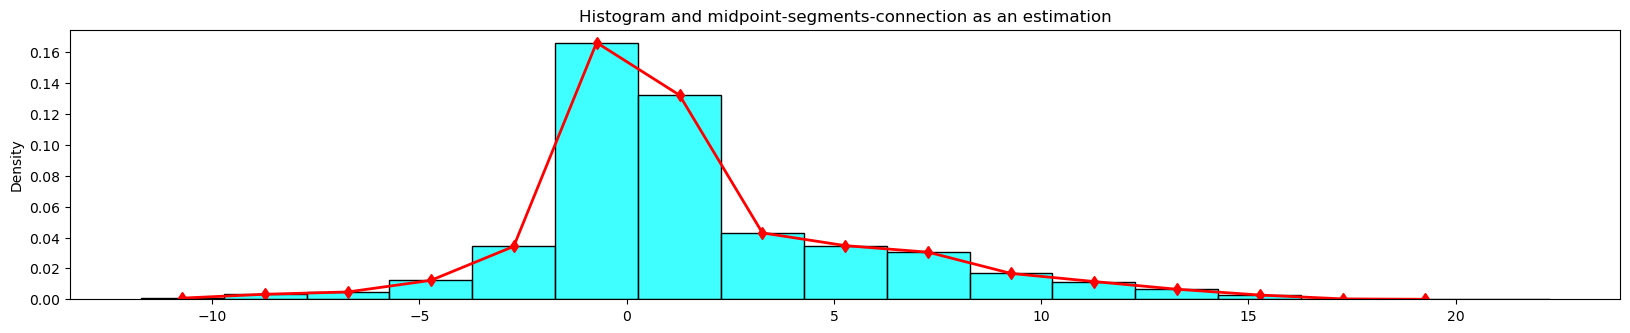

In [5]:
plot_hist_midpoint(x, 2)

Integration of true-density: 0.9999985477488721
Integration of custom-binwidth [bin = 2]: 0.99875, cust_err = 0.0012485477488720642


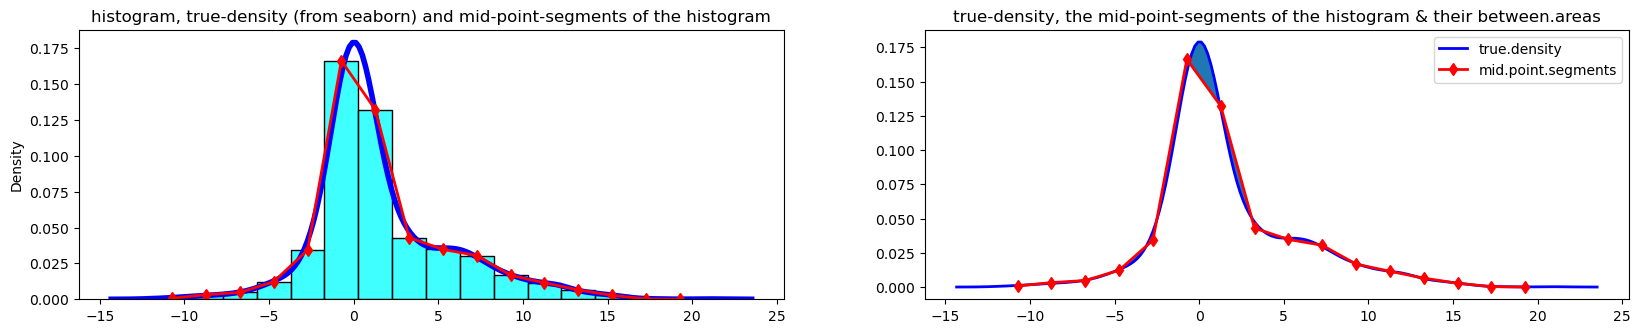

In [6]:
illustration_area(x, 2)

#### Wraping up into a function `core_idea`

Integration of true-density: 0.9999985477488721
Integration of custom-binwidth: 0.9987499999999994, cust_err = 0.0012485477488727303
Integration of optimal-biwidth: 0.9989999999999996, optm_err = 0.0009985477488725358


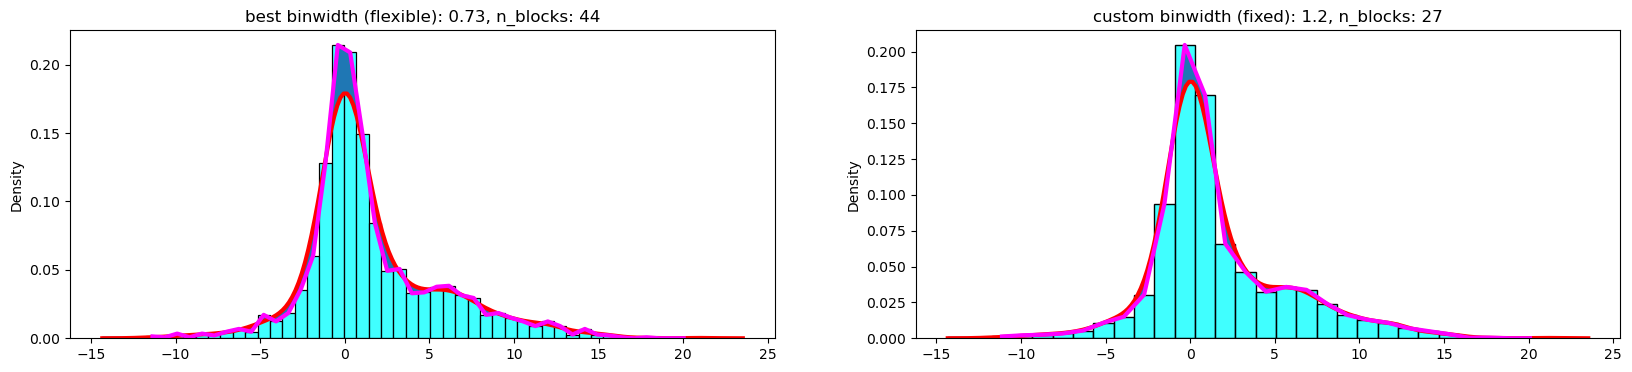

In [7]:
def core_idea(ser, bw, dx = 1e-4):
    x_sort = sorted(ser)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
    x_s, y = sns.distplot(x_sort, hist=False, ax=ax[0]).get_lines()[0].get_data()
    opt_bw = (ser.max() - ser.min())/np.sqrt(len(ser))

    x_best, y_best = est_get_kernel(ser, opt_bw)
    x_bw, y_bw = est_get_kernel(ser, bw)

    ax[0].plot(x_s, y, 'red', linewidth=3)
    ax[0].plot(x_best, y_best, 'magenta', linewidth=3)
    ax[0].set_title(f"best binwidth (flexible): {np.round(opt_bw, 3)}, n_blocks: {len(y_best)}")
    sns.histplot(ser, stat="density", binwidth=opt_bw, color="cyan", ax=ax[0])
    yinterp = array_interpolation(x_s, x_best, y_best)
    ax[0].fill_between(x_s, y, yinterp, interpolate=True)

    ax[1].plot(x_s, y, 'red', linewidth=3)
    ax[1].plot(x_bw, y_bw, 'magenta', linewidth=3)
    sns.histplot(ser, stat="density", binwidth=bw, color="cyan", ax=ax[1])
    ax[1].set_title(f"custom binwidth (fixed): {bw}, n_blocks: {len(y_bw)}")
    yinterp = array_interpolation(x_s, x_bw, y_bw)
    ax[1].fill_between(x_s, y, yinterp, interpolate=True)    

    true_integration = np.trapz(y, x_s, dx = dx)
    optional_integrate = np.trapz(y_bw, x_bw, dx = dx)
    optimal_integrate = np.trapz(y_best, x_best, dx = dx)
    
    print(f"Integration of true-density: {true_integration}")
    print(f"Integration of custom-binwidth: {optional_integrate}, cust_err = {abs(true_integration - optional_integrate)}")
    print(f"Integration of optimal-biwidth: {optimal_integrate}, optm_err = {abs(true_integration - optimal_integrate)}")

    return abs(true_integration - optional_integrate), abs(true_integration - optimal_integrate)

cust_err, opt_err = core_idea(x, 1.2)

argv_dist_lambda

Integration of true-density: 0.9999985477488721
Integration of custom-binwidth: 0.9989999999999999, cust_err = 0.0009985477488722028
Integration of optimal-biwidth: 0.9989999999999996, optm_err = 0.0009985477488725358


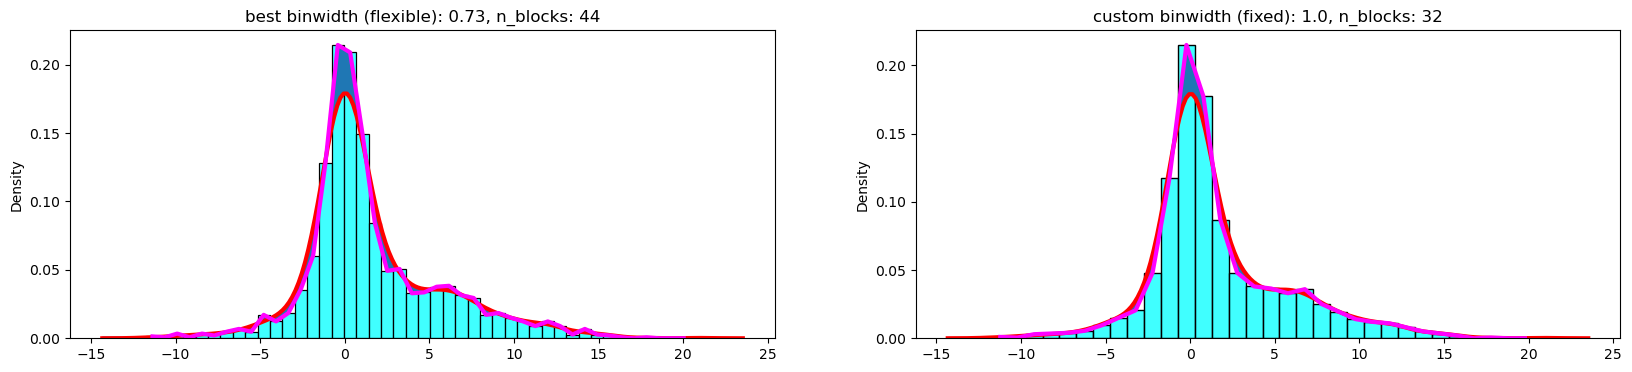

In [8]:
cust_err, opt_err = core_idea(x, 1.)

Integration of true-density: 0.9999985477488721
Integration of custom-binwidth: 0.9987499999999998, cust_err = 0.0012485477488722863
Integration of optimal-biwidth: 0.9989999999999996, optm_err = 0.0009985477488725358


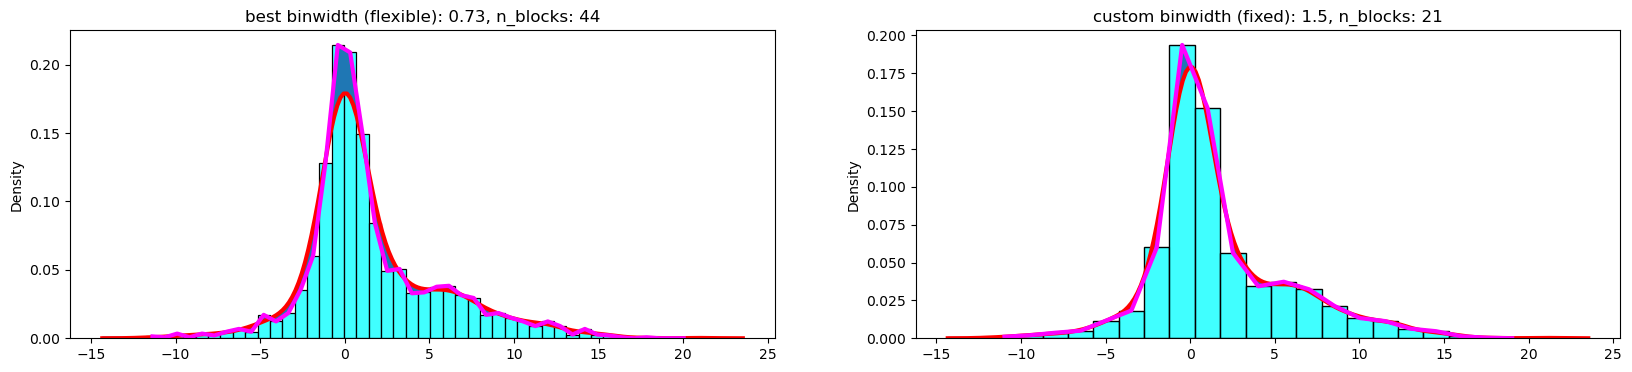

In [9]:
cust_err, opt_err = core_idea(x, 1.5)

### Error calculation

(0.0009985477488725358, 0.0012485477488727303, 0.0012485477488722863)

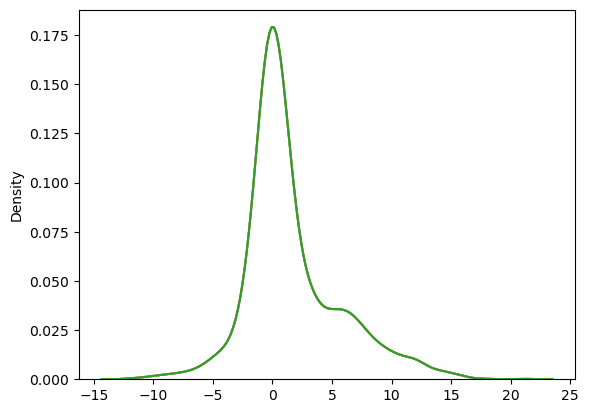

In [10]:
error_calc(x), error_calc(x, 1.2), error_calc(x, 1.5)

,hour,day,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
0,6,20230501,0.014272,0.089455,0.055294,0.026722,0.054023
1,6,20230502,0.014721,0.111507,0.028993,0.013247,0.036823
2,6,20230503,0.002371,0.161911,0.121106,0.087720,0.053538
3,6,20230504,0.003203,0.173438,0.126462,0.098470,0.078521
4,6,20230505,0.017064,0.116712,0.036067,0.016143,0.038885
5,6,20230506,0.009303,0.091629,0.055915,0.000014,0.055886
6,6,20230507,0.011378,0.139255,0.060774,0.025331,0.007581
7,6,20230508,0.006253,0.136504,0.121880,0.027173,0.006978
8,6,20230509,0.013271,0.124410,0.049531,0.020546,0.036218
9,6,20230510,0.010915,0.159850,0.075151,0.064222,0.012281


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.011552,0.125144,0.072030,0.031730,0.030567
std,0.006659,0.027291,0.029846,0.023240,0.024223
min,0.001875,0.054113,0.003900,0.000014,0.001460
25%,0.006796,0.106329,0.056133,0.016447,0.011439
50%,0.011027,0.124410,0.070415,0.026722,0.024542
75%,0.015261,0.143416,0.090931,0.039483,0.039858
max,0.031133,0.173438,0.126462,0.098470,0.088510


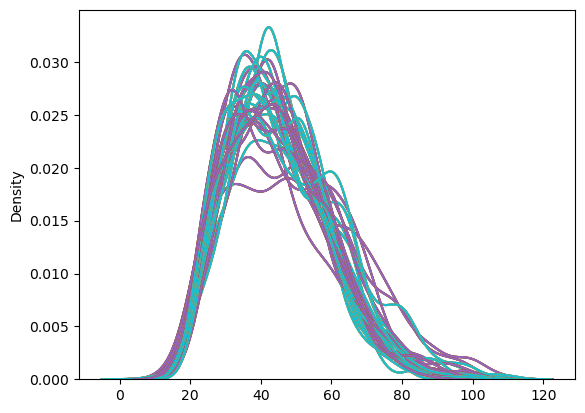

In [11]:
def find_err_by_hour(input_data, hour, bw = None):
    ext_df = input_data[(input_data['diff'] >= 0) & (input_data['diff'] <= 240) & (input_data['hour'] == hour)]
    ext_df = ext_df.sort_values(by='diff')
    count_df = ext_df.groupby('diff').count()['kensa']
    daylist = sorted(ext_df.knfltd.unique())
    err_df = pd.DataFrame({})
    for dd in daylist:
        serd = ext_df.loc[ext_df.knfltd == dd, 'diff'].reset_index(drop=True)
        tmp_df = pd.DataFrame({'hour': hour, 'day': [dd],
                               'optm_err': error_calc(serd),
                                'cust_err_06': error_calc(serd, 6),
                                'cust_err_08': error_calc(serd, 8),
                                'cust_err_10': error_calc(serd, 10),
                                'cust_err_12': error_calc(serd, 12)
                              })
        err_df = pd.concat([err_df, tmp_df]).reset_index(drop=True)
        
    return err_df, err_df.drop(columns=['hour']).describe()

err_df, err_df_stats = find_err_by_hour(psg_by_lane, 6)
display(err_df)
err_df_stats

In [12]:
err_df_stats.loc['mean'].min()

0.011552186079505639

### Include optimal-binwidth

At hour = 6, min_err = optm_err [0.011552186079505639],                              most_consistency: optm_err [0.006658659459250968]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.011552,0.125144,0.072030,0.031730,0.030567
std,0.006659,0.027291,0.029846,0.023240,0.024223
min,0.001875,0.054113,0.003900,0.000014,0.001460
25%,0.006796,0.106329,0.056133,0.016447,0.011439
50%,0.011027,0.124410,0.070415,0.026722,0.024542
75%,0.015261,0.143416,0.090931,0.039483,0.039858
max,0.031133,0.173438,0.126462,0.098470,0.088510


At hour = 7, min_err = optm_err [0.006131355301873186],                              most_consistency: optm_err [0.007601086492295355]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.006131,0.156293,0.104062,0.063327,0.037898
std,0.007601,0.014234,0.018596,0.026687,0.023230
min,0.000712,0.128627,0.059330,0.007739,0.004899
25%,0.001051,0.147790,0.090638,0.039598,0.018505
50%,0.002477,0.159394,0.106235,0.066517,0.030366
75%,0.007610,0.163665,0.118659,0.085056,0.062507
max,0.031689,0.183286,0.134392,0.108606,0.080148


At hour = 8, min_err = optm_err [0.0033686703712528907],                              most_consistency: optm_err [0.004967572456769765]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.003369,0.159742,0.117845,0.081240,0.057391
std,0.004968,0.017352,0.014285,0.017487,0.018772
min,0.000523,0.117500,0.088865,0.037582,0.013738
25%,0.001016,0.153293,0.108801,0.070465,0.046290
50%,0.001508,0.161319,0.117283,0.085446,0.063481
75%,0.002844,0.166911,0.128522,0.091679,0.071624
max,0.024576,0.209556,0.151839,0.106906,0.087037


At hour = 9, min_err = optm_err [0.0026698987545648355],                              most_consistency: optm_err [0.0023246352013086336]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.002670,0.158574,0.115841,0.086371,0.064029
std,0.002325,0.011533,0.013784,0.013949,0.017539
min,0.000466,0.131515,0.083222,0.062106,0.028087
25%,0.001000,0.153003,0.108716,0.078690,0.055726
50%,0.001651,0.158686,0.115935,0.085515,0.068248
75%,0.003703,0.165176,0.124343,0.095398,0.076250
max,0.009385,0.188455,0.140746,0.111779,0.093037


At hour = 10, min_err = optm_err [0.008301700997910314],                              most_consistency: optm_err [0.007903994079792316]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.008302,0.154381,0.108481,0.074563,0.051374
std,0.007904,0.014576,0.019646,0.020900,0.023871
min,0.000912,0.124518,0.070759,0.019299,0.001687
25%,0.002468,0.144761,0.099363,0.062095,0.031045
50%,0.004843,0.154975,0.113047,0.080514,0.053586
75%,0.014659,0.166918,0.122492,0.088547,0.069253
max,0.026050,0.179556,0.140664,0.107488,0.086921


At hour = 11, min_err = optm_err [0.004474423335421685],                              most_consistency: optm_err [0.00525274038821634]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.004474,0.161227,0.112125,0.088475,0.062089
std,0.005253,0.013904,0.014999,0.019805,0.021141
min,0.000659,0.129702,0.068075,0.036227,0.009910
25%,0.001678,0.155755,0.103877,0.079704,0.049224
50%,0.002183,0.161672,0.117690,0.091811,0.069350
75%,0.004020,0.170570,0.121227,0.099896,0.074747
max,0.019710,0.181525,0.136420,0.117661,0.098942


At hour = 12, min_err = optm_err [0.008346678050214865],                              most_consistency: optm_err [0.009027393347866862]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.008347,0.159121,0.111521,0.085125,0.056715
std,0.009027,0.015690,0.020678,0.019533,0.024452
min,0.001285,0.118731,0.067915,0.039586,0.001719
25%,0.002321,0.149299,0.097857,0.069087,0.045552
50%,0.003797,0.158437,0.113316,0.089945,0.064203
75%,0.011103,0.168615,0.125615,0.100162,0.071125
max,0.031537,0.186382,0.153694,0.111813,0.091547


At hour = 13, min_err = optm_err [0.007384894424643607],                              most_consistency: optm_err [0.0074195513569266435]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.007385,0.159649,0.115069,0.079808,0.055901
std,0.007420,0.018465,0.013666,0.021428,0.023612
min,0.000851,0.113014,0.080753,0.032014,0.009285
25%,0.001981,0.148230,0.106481,0.063302,0.034741
50%,0.003396,0.161139,0.112659,0.084120,0.064162
75%,0.011933,0.176872,0.123230,0.099215,0.073164
max,0.030986,0.188554,0.146135,0.106528,0.097549


At hour = 14, min_err = optm_err [0.007604078678115487],                              most_consistency: optm_err [0.008121706407667191]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.007604,0.160345,0.111875,0.078926,0.060848
std,0.008122,0.015495,0.019249,0.020844,0.022574
min,0.001208,0.127871,0.072682,0.039295,0.012664
25%,0.002745,0.150846,0.099262,0.065793,0.044867
50%,0.003448,0.161600,0.117009,0.083347,0.066795
75%,0.008679,0.169765,0.124036,0.095715,0.077018
max,0.031277,0.188637,0.144189,0.116448,0.094711


At hour = 15, min_err = optm_err [0.008388522190544584],                              most_consistency: optm_err [0.006003979753953997]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.008389,0.159895,0.115064,0.081012,0.059177
std,0.006004,0.012809,0.014945,0.017686,0.019842
min,0.001085,0.137218,0.070112,0.047680,0.024386
25%,0.003594,0.150703,0.106910,0.066952,0.046788
50%,0.007144,0.160532,0.116184,0.084002,0.059150
75%,0.010890,0.171330,0.124379,0.095648,0.072073
max,0.024390,0.181553,0.145918,0.112164,0.102708


At hour = 16, min_err = optm_err [0.007026055248542882],                              most_consistency: optm_err [0.006954635532665655]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.007026,0.156873,0.112433,0.083781,0.060495
std,0.006955,0.014432,0.013713,0.023423,0.022148
min,0.001657,0.132798,0.083992,0.024259,0.008714
25%,0.002335,0.149360,0.104164,0.075317,0.057773
50%,0.003427,0.155897,0.113908,0.090569,0.064300
75%,0.008735,0.166136,0.121045,0.099267,0.076757
max,0.023052,0.186907,0.136597,0.116424,0.090009


At hour = 17, min_err = optm_err [0.008484020366767918],                              most_consistency: optm_err [0.008971640951826482]


,optm_err,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.008484,0.157031,0.114768,0.082525,0.060116
std,0.008972,0.013333,0.017933,0.021887,0.023250
min,0.000852,0.138852,0.077428,0.037355,0.008221
25%,0.002601,0.146510,0.101686,0.067716,0.043108
50%,0.003988,0.153316,0.116970,0.086738,0.066939
75%,0.011653,0.165839,0.128881,0.099489,0.073439
max,0.032814,0.188461,0.141963,0.117438,0.101036


,hour,min_avg_err,min_avg_err_val,min_std_err,min_std_err_val
0,6,optm_err,0.011552,optm_err,0.006659
0,7,optm_err,0.006131,optm_err,0.007601
0,8,optm_err,0.003369,optm_err,0.004968
0,9,optm_err,0.002670,optm_err,0.002325
0,10,optm_err,0.008302,optm_err,0.007904
0,11,optm_err,0.004474,optm_err,0.005253
0,12,optm_err,0.008347,optm_err,0.009027
0,13,optm_err,0.007385,optm_err,0.007420
0,14,optm_err,0.007604,optm_err,0.008122
0,15,optm_err,0.008389,optm_err,0.006004


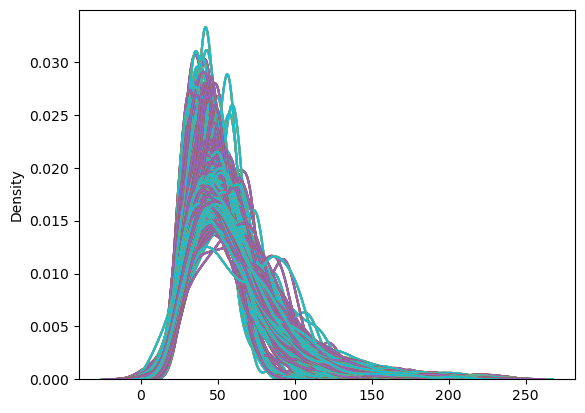

In [13]:
opt_summary_df = pd.DataFrame({})
for hh in range(6, 18):
    err_df, err_df_stats = find_err_by_hour(psg_by_lane, hh)
    min_avg_err, min_avg_err_val = err_df_stats.loc['mean'].idxmin(), err_df_stats.loc['mean'].min()
    min_std_err, min_std_err_val = err_df_stats.loc['std'].idxmin(), err_df_stats.loc['std'].min()
    print(f"At hour = {hh}, min_err = {min_avg_err} [{min_avg_err_val}],  \
                            most_consistency: {min_std_err} [{min_std_err_val}]")
    opt_summary_df = pd.concat([opt_summary_df, 
                                pd.DataFrame({'hour': hh, 
                                              'min_avg_err': [min_avg_err],
                                              'min_avg_err_val': min_avg_err_val,
                                              'min_std_err': [min_std_err],
                                              'min_std_err_val': min_std_err_val
                                             })], axis=0)
    display(err_df_stats)
    
opt_summary_df

### Without optimal-values

At hour = 6, min_err = cust_err_12 [0.030566533450327588],                              most_consistency: cust_err_10 [0.02324044018962747]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.125144,0.072030,0.031730,0.030567
std,0.027291,0.029846,0.023240,0.024223
min,0.054113,0.003900,0.000014,0.001460
25%,0.106329,0.056133,0.016447,0.011439
50%,0.124410,0.070415,0.026722,0.024542
75%,0.143416,0.090931,0.039483,0.039858
max,0.173438,0.126462,0.098470,0.088510


At hour = 7, min_err = cust_err_12 [0.03789827770793535],                              most_consistency: cust_err_06 [0.014233771641164577]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.156293,0.104062,0.063327,0.037898
std,0.014234,0.018596,0.026687,0.023230
min,0.128627,0.059330,0.007739,0.004899
25%,0.147790,0.090638,0.039598,0.018505
50%,0.159394,0.106235,0.066517,0.030366
75%,0.163665,0.118659,0.085056,0.062507
max,0.183286,0.134392,0.108606,0.080148


At hour = 8, min_err = cust_err_12 [0.05739146023630517],                              most_consistency: cust_err_08 [0.014285438727376438]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.159742,0.117845,0.081240,0.057391
std,0.017352,0.014285,0.017487,0.018772
min,0.117500,0.088865,0.037582,0.013738
25%,0.153293,0.108801,0.070465,0.046290
50%,0.161319,0.117283,0.085446,0.063481
75%,0.166911,0.128522,0.091679,0.071624
max,0.209556,0.151839,0.106906,0.087037


At hour = 9, min_err = cust_err_12 [0.06402912143321159],                              most_consistency: cust_err_06 [0.011533020594572951]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.158574,0.115841,0.086371,0.064029
std,0.011533,0.013784,0.013949,0.017539
min,0.131515,0.083222,0.062106,0.028087
25%,0.153003,0.108716,0.078690,0.055726
50%,0.158686,0.115935,0.085515,0.068248
75%,0.165176,0.124343,0.095398,0.076250
max,0.188455,0.140746,0.111779,0.093037


At hour = 10, min_err = cust_err_12 [0.05137409202673882],                              most_consistency: cust_err_06 [0.01457561461963417]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.154381,0.108481,0.074563,0.051374
std,0.014576,0.019646,0.020900,0.023871
min,0.124518,0.070759,0.019299,0.001687
25%,0.144761,0.099363,0.062095,0.031045
50%,0.154975,0.113047,0.080514,0.053586
75%,0.166918,0.122492,0.088547,0.069253
max,0.179556,0.140664,0.107488,0.086921


At hour = 11, min_err = cust_err_12 [0.062089005263157006],                              most_consistency: cust_err_06 [0.013904095597165642]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.161227,0.112125,0.088475,0.062089
std,0.013904,0.014999,0.019805,0.021141
min,0.129702,0.068075,0.036227,0.009910
25%,0.155755,0.103877,0.079704,0.049224
50%,0.161672,0.117690,0.091811,0.069350
75%,0.170570,0.121227,0.099896,0.074747
max,0.181525,0.136420,0.117661,0.098942


At hour = 12, min_err = cust_err_12 [0.05671530229626873],                              most_consistency: cust_err_06 [0.015689580220621804]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.159121,0.111521,0.085125,0.056715
std,0.015690,0.020678,0.019533,0.024452
min,0.118731,0.067915,0.039586,0.001719
25%,0.149299,0.097857,0.069087,0.045552
50%,0.158437,0.113316,0.089945,0.064203
75%,0.168615,0.125615,0.100162,0.071125
max,0.186382,0.153694,0.111813,0.091547


At hour = 13, min_err = cust_err_12 [0.05590140437841366],                              most_consistency: cust_err_08 [0.013666333572424381]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.159649,0.115069,0.079808,0.055901
std,0.018465,0.013666,0.021428,0.023612
min,0.113014,0.080753,0.032014,0.009285
25%,0.148230,0.106481,0.063302,0.034741
50%,0.161139,0.112659,0.084120,0.064162
75%,0.176872,0.123230,0.099215,0.073164
max,0.188554,0.146135,0.106528,0.097549


At hour = 14, min_err = cust_err_12 [0.060848057257075996],                              most_consistency: cust_err_06 [0.015494681703323977]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.160345,0.111875,0.078926,0.060848
std,0.015495,0.019249,0.020844,0.022574
min,0.127871,0.072682,0.039295,0.012664
25%,0.150846,0.099262,0.065793,0.044867
50%,0.161600,0.117009,0.083347,0.066795
75%,0.169765,0.124036,0.095715,0.077018
max,0.188637,0.144189,0.116448,0.094711


At hour = 15, min_err = cust_err_12 [0.05917718682631179],                              most_consistency: cust_err_06 [0.012809231720426298]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.159895,0.115064,0.081012,0.059177
std,0.012809,0.014945,0.017686,0.019842
min,0.137218,0.070112,0.047680,0.024386
25%,0.150703,0.106910,0.066952,0.046788
50%,0.160532,0.116184,0.084002,0.059150
75%,0.171330,0.124379,0.095648,0.072073
max,0.181553,0.145918,0.112164,0.102708


At hour = 16, min_err = cust_err_12 [0.06049507463494765],                              most_consistency: cust_err_08 [0.01371347567664151]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.156873,0.112433,0.083781,0.060495
std,0.014432,0.013713,0.023423,0.022148
min,0.132798,0.083992,0.024259,0.008714
25%,0.149360,0.104164,0.075317,0.057773
50%,0.155897,0.113908,0.090569,0.064300
75%,0.166136,0.121045,0.099267,0.076757
max,0.186907,0.136597,0.116424,0.090009


At hour = 17, min_err = cust_err_12 [0.06011604095119001],                              most_consistency: cust_err_06 [0.013332997788778701]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.157031,0.114768,0.082525,0.060116
std,0.013333,0.017933,0.021887,0.023250
min,0.138852,0.077428,0.037355,0.008221
25%,0.146510,0.101686,0.067716,0.043108
50%,0.153316,0.116970,0.086738,0.066939
75%,0.165839,0.128881,0.099489,0.073439
max,0.188461,0.141963,0.117438,0.101036


At hour = 18, min_err = cust_err_12 [0.06309878835135699],                              most_consistency: cust_err_06 [0.013986660026153976]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.158208,0.113921,0.080770,0.063099
std,0.013987,0.022185,0.021174,0.025634
min,0.127536,0.064025,0.039640,0.006470
25%,0.150804,0.102297,0.063702,0.038089
50%,0.162343,0.118230,0.089192,0.070339
75%,0.166227,0.126712,0.096515,0.083099
max,0.184324,0.150802,0.119251,0.092523


At hour = 19, min_err = cust_err_12 [0.05940255136417518],                              most_consistency: cust_err_06 [0.015116401759644071]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.156706,0.108966,0.081955,0.059403
std,0.015116,0.017466,0.019138,0.026155
min,0.128586,0.067760,0.036151,0.000614
25%,0.147042,0.102205,0.072929,0.037977
50%,0.157101,0.111625,0.082411,0.069699
75%,0.165090,0.121819,0.096386,0.077925
max,0.197247,0.134228,0.116036,0.097247


At hour = 20, min_err = cust_err_12 [0.06361459346830754],                              most_consistency: cust_err_10 [0.01723975209472331]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.158706,0.116494,0.082747,0.063615
std,0.018567,0.018127,0.017240,0.024018
min,0.119905,0.047412,0.049034,0.010209
25%,0.146917,0.111389,0.068407,0.051663
50%,0.155808,0.117055,0.084402,0.069261
75%,0.169991,0.127900,0.096865,0.079998
max,0.195092,0.140124,0.114569,0.096613


At hour = 20, min_err = cust_err_12 [0.06361459346830754],                              most_consistency: cust_err_10 [0.01723975209472331]


,cust_err_06,cust_err_08,cust_err_10,cust_err_12
count,31.000000,31.000000,31.000000,31.000000
mean,0.158706,0.116494,0.082747,0.063615
std,0.018567,0.018127,0.017240,0.024018
min,0.119905,0.047412,0.049034,0.010209
25%,0.146917,0.111389,0.068407,0.051663
50%,0.155808,0.117055,0.084402,0.069261
75%,0.169991,0.127900,0.096865,0.079998
max,0.195092,0.140124,0.114569,0.096613


,hour,min_avg_err,min_avg_err_val,sd(min_avg_err),min_std_err,min_std_err_val
0,6,cust_err_12,0.030567,0.024223,cust_err_10,0.023240
0,7,cust_err_12,0.037898,0.023230,cust_err_06,0.014234
0,8,cust_err_12,0.057391,0.018772,cust_err_08,0.014285
0,9,cust_err_12,0.064029,0.017539,cust_err_06,0.011533
0,10,cust_err_12,0.051374,0.023871,cust_err_06,0.014576
0,11,cust_err_12,0.062089,0.021141,cust_err_06,0.013904
0,12,cust_err_12,0.056715,0.024452,cust_err_06,0.015690
0,13,cust_err_12,0.055901,0.023612,cust_err_08,0.013666
0,14,cust_err_12,0.060848,0.022574,cust_err_06,0.015495
0,15,cust_err_12,0.059177,0.019842,cust_err_06,0.012809


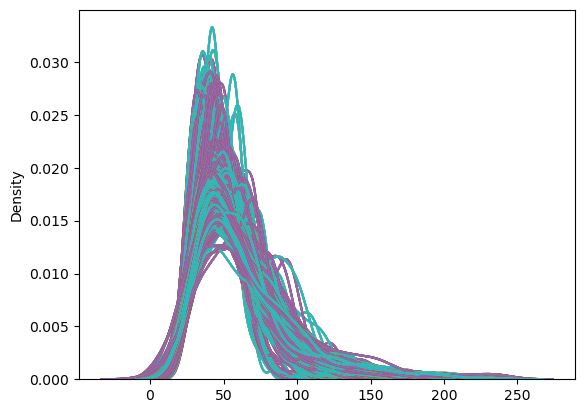

In [14]:
fixed_bin_summary_df = pd.DataFrame({})
for hh in range(6, 22):
    time_h = str(hh)
    if hh <= 20:
        hh = hh
    else:
        hh = 20
    err_df, err_df_stats = find_err_by_hour(psg_by_lane, hh)
    err_df_stats = err_df_stats.drop(columns = 'optm_err')
    min_avg_err, min_avg_err_val = err_df_stats.loc['mean'].idxmin(), err_df_stats.loc['mean'].min()
    min_std_err, min_std_err_val = err_df_stats.loc['std'].idxmin(), err_df_stats.loc['std'].min()
    print(f"At hour = {hh}, min_err = {min_avg_err} [{min_avg_err_val}],  \
                            most_consistency: {min_std_err} [{min_std_err_val}]")
    fixed_bin_summary_df = pd.concat([fixed_bin_summary_df, 
                                        pd.DataFrame({'hour': [time_h],
                                                      'min_avg_err': [min_avg_err],
                                                      'min_avg_err_val': min_avg_err_val,
                                                      'sd(min_avg_err)' : err_df_stats.loc['std', min_avg_err],
                                                      'min_std_err': [min_std_err],
                                                      'min_std_err_val': min_std_err_val
                                                     })], axis=0)
    display(err_df_stats)
    
fixed_bin_summary_df

In [15]:
fixed_bin_summary_df

,hour,min_avg_err,min_avg_err_val,sd(min_avg_err),min_std_err,min_std_err_val
0,6,cust_err_12,0.030567,0.024223,cust_err_10,0.023240
0,7,cust_err_12,0.037898,0.023230,cust_err_06,0.014234
0,8,cust_err_12,0.057391,0.018772,cust_err_08,0.014285
0,9,cust_err_12,0.064029,0.017539,cust_err_06,0.011533
0,10,cust_err_12,0.051374,0.023871,cust_err_06,0.014576
0,11,cust_err_12,0.062089,0.021141,cust_err_06,0.013904
0,12,cust_err_12,0.056715,0.024452,cust_err_06,0.015690
0,13,cust_err_12,0.055901,0.023612,cust_err_08,0.013666
0,14,cust_err_12,0.060848,0.022574,cust_err_06,0.015495
0,15,cust_err_12,0.059177,0.019842,cust_err_06,0.012809


### Approximation with numpy only & comparison

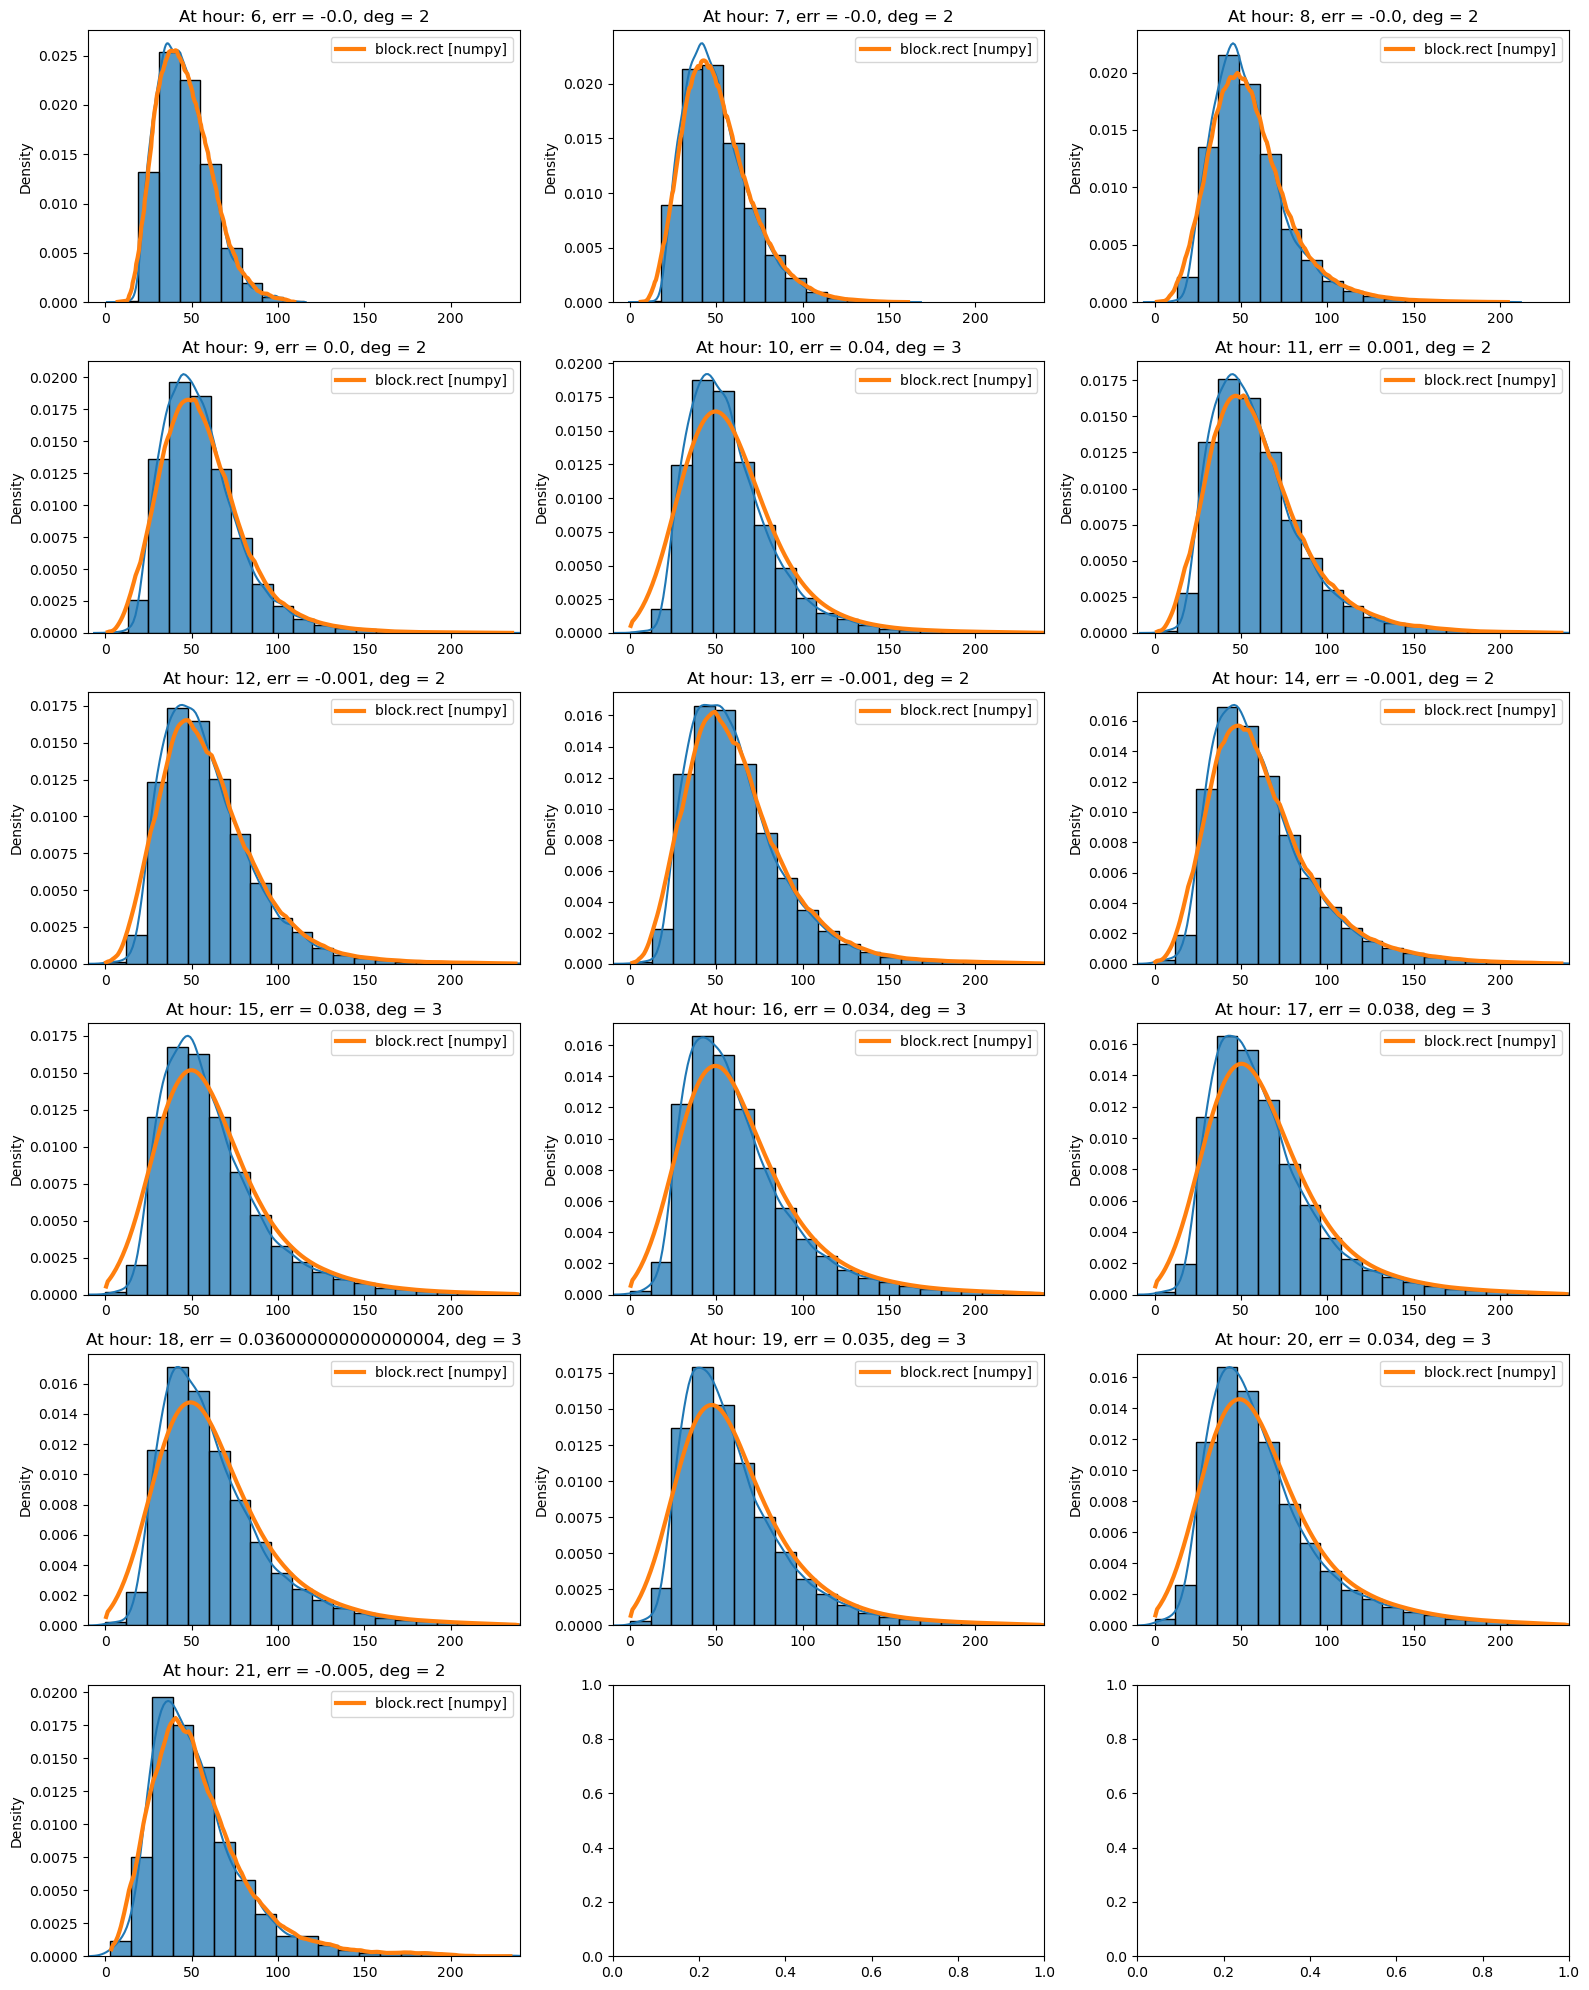

In [16]:
def gaussian(x, mu=0, sig=1):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def get_mid_rect(ser, bw):
    """
        To get the mid-point from any input of series (ser) and bin-width (bw)
    """
    xb = np.arange(ser.min(), ser.max(), bw)
    x_range = range(len(xb)-1)
    yb = [((ser >= xb[idx]) & (ser <= xb[idx + 1])).sum() / (bw*len(ser)) for idx in x_range]
    xb = [(xb[idx] + xb[idx + 1])/2 for idx in x_range]

    return xb, yb

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

input_df = psg_by_lane.copy()
deg_df = pd.DataFrame({})
figs, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 20))
axes = axes.ravel()
for idx, hour in enumerate(range(6, 22)):
    
    X = input_df.loc[(input_df['hour'] == hour) & (input_df['diff'] >= 0) & (input_df['diff'] <= 240), 'diff'].values
    # using numpy approximation
    n = len(X)
    N_split = 250
    h = 1 / np.sqrt(n)
    bw = (X.max() - X.min()) / N_split
    u = np.linspace(X.min(), X.max(), N_split)
    xb, yb = get_mid_rect(X, bw)
    
    # using seaborn.distplot
    x_s, y = sns.distplot(X, hist=False, ax=axes[idx]).get_lines()[0].get_data()
    for deg in range(2, 4):       
        yb = smooth(smooth(yb, 32 + deg), 3)
        err = np.trapz(yb, xb, dx=1e-4) - np.trapz(y, x_s, dx=1e-4)
        if abs(err) < 1e-2:
            break

    # axes[idx].plot(x_s, y, label='true [seaborn]', linewidth=3)
    axes[idx].plot(xb, yb, label='block.rect [numpy]', linewidth=3)
    axes[idx].set_xlim([-10, 240])
    axes[idx].set_title(f"At hour: {hour}, err = {np.round(err, 3)}, deg = {deg}")
    sns.histplot(X, stat="density", binwidth=12, kde=False, ax=axes[idx])
    
    deg_df.loc[hour, 'deg'] = deg
    
    axes[idx].legend()
    plt.tight_layout()

In [17]:
display(deg_df.deg.value_counts())
deg_df

deg
2.0    9
3.0    7
Name: count, dtype: int64

,deg
6,2.0
7,2.0
8,2.0
9,2.0
10,3.0
11,2.0
12,2.0
13,2.0
14,2.0
15,3.0
